# This is a Man's word

## Project setup

Mouting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing dependencies

In [2]:
# Toggle in order to install dependencies as you run the notebook
INSTALL_DEPS = False

if INSTALL_DEPS:
  !pip install nltk gensim spacy
  !pip install empath
  !python -m spacy download en
  !python -m nltk.downloader punkt
  !python -m nltk.downloader all-corpora
  !pip install fastparquet
  !pip install toolz 

In [3]:
if INSTALL_DEPS:
  !pip install pyLDAvis
  !pip install "openpyxl>=3.0"

### Importing libraries

In [63]:
import pandas as pd
import bz2
import json
import string
import re
import matplotlib.pyplot as plt
import requests
import nltk
import gc

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from functools import partial
from toolz import compose
from itertools import product

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

In [5]:
if INSTALL_DEPS:
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')

We disable the warnings - in general it's a bad practice and should be avoided in any longer-maintained project. Nonetheless, while training the model we get a warning about a deprecated function in one of the dependencies - it's prints the message thousands of times and thus slows down the training phase and affects readability.

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Loading dataset

In [26]:
def get_path_to_file(year):
  return f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'

def load_speaker_attrs():
  return pd.read_parquet("/content/drive/MyDrive/Project datasets/speaker_attributes.parquet")

def load_attrs_labels():
  return pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

def get_wikidata_uri(q):
  return f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={q}&languages=en&format=json"

## Processing speaker attributes

### Resolving Q-codes


The functions below were written by us before receiving the additional dataset containing label and description for QIDs. Right now this code is obsolete, but we leave it for a reference. Our approach was to query WikiData API for all of the occuring Q-codes, and interpolated the Q-codes with fetched labels.

In [27]:
def query_wikidata_label(Q):
  """Resolve what is the label of a given Q-code."""
  data = requests.get(get_wikidata_uri(Q)).json()
  try:
    return data['entities'][Q]['labels']['en']['value']
  except KeyError:
    return ''


def extract_q_codes_labels(s, count = 200):
  """ Extracts country labels for most common countries."""
  countries_codes = list(set(s.explode()))
  common_countries_codes = [x for x, _ in Counter(countries_codes).most_common(count)]

  countries_labels = {}

  for code in common_countries_codes:
    try:
      countries_labels[code] = query_wikidata_label(code)
    except:
      print(f'Error, could not resolve code {code}')
  return countries_labels


def interpolate_q_codes_labels(s):
  """Given a series s with Q-codes, fetches representation of a Q-code (label)
  from wikidata and interpolates the values."""
  labels = extract_q_codes_labels(s)
  return s.apply(lambda codes: [labels.get(code, '') for code in codes] if codes is not None else None)


def resolve_q_codes(df, columns):
  """Interpolates q-codes in dataframe for specified columns."""
  for col in columns:
    df[col] = interpolate_q_codes_labels(df[col])

And here is the actually used interface after receiving the speakers attribute data.


In [28]:
def resolve_q_code(labels, q):
  '''Returns label of the QCODE if found.'''
  try:
    return labels.loc[q]['Label']
  except KeyError:
    return None

def untangle_codes(codes):
  discard_none = lambda xs: filter(lambda x: x is not None, xs)
  resolve_code = partial(resolve_q_code, labels)
  return compose(
    list,
    discard_none,
    partial(map, resolve_code)
  )(codes)

def interpolate_q_codes_new_way(df, labels, columns):
  '''Adds labeled features to the df.'''
  for col in columns:
    df[col] = df[col].apply(lambda codes: untangle_codes(codes, labels) if codes is not None else None)

We want to associate the quote's speaker with an entry in speaker attributes dataframe. However, as in the Quotebank aliases might have been used, we construct an **Alias Name -> Index in Speaker attrs** mapping.

This mapping is then left-joined with quote's speaker and with speaker attrs so that we can have full speaker metadata for a quote.

In [29]:
def construct_speaker_names(speaker_attrs):
  """Associates the speaker attributes index with all speaker aliases"""
  
  speaker_names = speaker_attrs.aliases.explode().append(speaker_attrs.label)
  speaker_names = speaker_names.drop(speaker_names[speaker_names.isna()].index)

  speaker_names_df = pd.DataFrame({"speaker": speaker_names, "speaker_attr_idx": speaker_names.index})
  speaker_names_df = speaker_names_df.set_index('speaker')
  return speaker_names_df


def clean_speaker_attrs(speaker_attrs):
  return speaker_attrs[['nationality', 'gender', 'occupation', 'label']].copy()

In [30]:
# If more columns with q-codes need to be resolved they should be added here
Q_CODES_COLUMNS = ['nationality', 'occupation', 'gender']


def process_speaker_attrs():
  speaker_attrs = load_speaker_attrs()
  attrs_labels = load_attrs_labels()

  interpolate_q_codes_new_way(speaker_attrs, attrs_labels, Q_CODES_COLUMNS)
  speaker_names_df = construct_speaker_names(speaker_attrs)
  trimmed_speaker_attrs = clean_speaker_attrs(speaker_attrs)

  return trimmed_speaker_attrs, speaker_names_df

**Run speaker attributes processing**

Processing speaker attrs due to its size takes time - we have run
it once and saved the results to pickle so that it can be loaded fast


In [31]:
# Toggle to 1 if you want to re-proces attrs (most likley you don't want to)
REPROCESS_SPEAKER_ATTRS = False

if REPROCESS_SPEAKER_ATTRS:
  speaker_attrs, speaker_names = process_speaker_attrs()
  speaker_attrs.to_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df.to_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

**Load cached processed speaker attributes**

In [32]:
# Toggle to 1 if you need speaker attributes in your further processing
# Note that later we merge it with quotes dataset so most likley it's not necessary
LOAD_SPEAKER_ATTRS = False

if LOAD_SPEAKER_ATTRS:
  speaker_attrs = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

## Loading Human Development Index

We download now the Human Development Index dataset (HDI). The first nationality mentioned in the dataset for a given speaker is the one that we will match with the corresponding HDI score. HDI is represented as a number from 0 to 1, but we narrow down ourselves to four categories of developemnt:

1. Very High
1. High
1. Medium
1. Low

with ranges defined by United Nations.

In [33]:
def load_HDI():
  return pd.read_excel('/content/drive/MyDrive/ADA/HDI_list.xlsx')


def merge_HDI_with_chunk(chunk_df):
  '''Merges HDI score with speaker's first nationality'''

  chunk_df['N'] = [next(iter(nationality), ' ') for nationality in chunk_df['nationality']]
  chunk_df = pd.merge(chunk_df, HDI, on='N') 
  return chunk_df


def merge_speaker_attrs_with_chunk(chunk_df):
  '''Merges speakers attributes data based on speaker column'''  
  chunk_df = chunk_df.join(speaker_names_df, on='speaker')

  # discard quotes for which the speaker could not be found
  chunk_df = chunk_df.drop(chunk_df[chunk_df.speaker_attr_idx.isna()].index)
  return chunk_df.join(speaker_attrs, on='speaker_attr_idx')

## Data cleaning

The next step is the data cleaning: we discard from the dataset those quotes with missing attributed speaker, gender, nationality or occupation. 


In [34]:
def discard_na(df, col):
  '''Drops rows with col value equal to None.'''
  df[col].replace('None', pd.NA, inplace=True)
  df.drop(df[df[col].isna() == True].index, inplace=True)

def clean_speaker(chunk_df):
  discard_na(chunk_df, 'speaker')
  return chunk_df

def clean_gender(chunk_df):
  '''Drops rows with missing gender.'''
  clean = lambda x: x[0] if x is not None and x[0] in ["male", "female"] else None
  chunk_df['gender'] = chunk_df['gender'].apply(clean)
  discard_na(chunk_df, 'gender')
  return chunk_df

def clean_occupation(chunk_df):
  '''Drops rows with missing occupation.'''
  discard_na(chunk_df, 'occupation')
  return chunk_df

def clean_nationality(chunk_df):
  '''Drops rows with missing nationality.'''
  discard_na(chunk_df, 'nationality')
  return chunk_df

Now we take care of the content of the quotes: the quotes of a chunk are cleaned and tokenized to obtain single words. All of these, excluding the stopwords, are lemmatized and saved as keywords. Lemmatization consists of grouping together the inflected forms of a word so that they can be analyzed as a single item.


In [35]:
ps = PorterStemmer()
lem = WordNetLemmatizer()


def normalize_quote(s:str) -> str:
    """
    Lower text, remove punctuation and extra whitespace.
    """
    
    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_punc(lower(s)))


def extract_keywords(text):
  """
  - Tokenize text
  - Excluded stop words
  - Lemmatized resulting keywords
  """

  stopwords = nltk.corpus.stopwords.words('english')
  allWords = nltk.tokenize.word_tokenize(text)

  allWords = [
    lem.lemmatize(word)
    for word in allWords
    if word not in stopwords and len(lem.lemmatize(word)) > 2
  ]
  return allWords

Then, we are interested in calculating the frequency of appearance of the keywords extracted from a chunk, and of the speakers' nationalities and occupations. 

In [36]:
def keywords_freq_distribution(chunk_df):
  combined_quotations = " ".join(entry for entry in chunk_df.quotation)
  keywords = extract_keywords(normalize_quote(combined_quotations))
  fd = nltk.FreqDist(keywords)
  return fd


def countries_distribution(chunk_df):
  countries = list(chunk_df.nationality.explode())
  return Counter(countries)


def occupations_distrubtion(chunk_df):
  occupations = list(chunk_df.occupation.explode())
  return Counter(occupations)


def split_into_keywords(chunk_df):
  return chunk_df.quotation.apply(lambda x: extract_keywords(normalize_quote(x)))

### Preprocessing chunks

All the previous preprocessing and cleaning operations are called into the following function to process each chunk.


In [37]:
COLUMNS_OF_INTEREST = [
  'numOccurrences', 'gender', 'occupation',
  'nationality', 'HDI rank', 'Development', 'keywords'
]

def preprocess_chunk(chunk_df):
  '''
  Apply basic preprocessing and data cleaning to a chunk
  - Merge the chunk with the speaker attributes and HDI indexes
  - Remove rows with missing speakers, nationalities, genders and occupations
  - Process features in a format more appropriate for our use case
  '''
  chunk_df = compose(
    merge_HDI_with_chunk,
    clean_occupation,
    clean_gender,
    clean_nationality,
    merge_speaker_attrs_with_chunk,
    clean_speaker,
  )(chunk_df)

  chunk_df['keywords'] = split_into_keywords(chunk_df)
  chunk_df.rename({"N": "nationality"}, inplace=True)
  chunk_df = chunk_df[COLUMNS_OF_INTEREST]
  return chunk_df

We extract a given number of chunks of specified size from the Quotebank file corresponding to a certain year. Then we process the chunk and calculate the distributions.

In [8]:
from datetime import datetime


def iterate_chunks(year, chunk_size, num_of_chunks):
  '''Extracts a number of chunks from the file corresponding to the specified year.'''

  with bz2.open(get_path_to_file(year), 'rb') as file:
    lines = []

    for i, line in enumerate(file):
      lines.append(json.loads(line))

      if i % chunk_size == 0 and i != 0:
        yield pd.DataFrame(lines)
        del lines[:]
        lines = []

        if i / chunk_size == num_of_chunks:
           return

    yield pd.DataFrame(lines)
    del lines[:]


def preprocess_chunks_in_year(year, chunk_size = 100_000, num_of_chunks=10):
  for i, chunk_df in enumerate(iterate_chunks(year, chunk_size, num_of_chunks)):
      print(f"[{datetime.now()}] Pre-processing chunk {i+1} out of {num_of_chunks}")

      processed_chunk_df = preprocess_chunk(chunk_df, aggregation)
      yield processed_chunk_df
      gc.collect()


def preprocess_and_cache_chunks(year):
  """
  Run preprocessing and cache intermediate results in the pickle format
  """
  for i, processed_chunk in enumerate(run_chunks_year(year, chunk_size=1_000_000, num_of_chunks=40)):
    processed_chunk.to_pickle(f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl')
  return i


def concatenate_preprocessed_chunks(year, chunks=6):
  chunks = [pd.read_pickle(f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl') for i in range(chunks)]
  df = pd.concat(chunks)
  df.to_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')


def read_preprocessed_from_year(year):
  return pd.read_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')

In [ ]:
# As an example, we take a chunk and process it.
# It only makes sense if we have previously loaded speaker attrs

if LOAD_SPEAKER_ATTRS:
  chunk_df = next(iterate_chunks(2020, 100_000, 3))

In [40]:
if LOAD_SPEAKER_ATTRS:
  processed_chunk_df = preprocess_chunk(chunk_df)
  processed_chunk_df

**Running pre-processing**

In [10]:
YEAR = 2020
PREPROCESS_YEAR = False

if PREPROCESS_YEAR:
  chunks_count = preprocess_and_cache_chunks()
  gc.collect()
  concatenate_preprocessed_chunks(year, chunks_count)

In [11]:
df = read_preprocessed_from_year(YEAR)
df

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords
0,0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]"
1,1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica..."
2,2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri..."
3,3,1,male,[handball player],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri..."
4,4,3,male,[basketball player],"[Luxembourg, United States of America]",23,Very High,"[protect, whats, stand, believe, always, faith..."
...,...,...,...,...,...,...,...,...
657236,30438,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi..."
657237,30439,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology..."
657238,30440,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]"
657239,30441,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w..."


## Topic Detection

### Preprocessing

We discard the most commonly occuring keywords which do not contribute towards better topic detection

In [12]:
IGNORED_KEYWORDS_FOR_TOPICS = ['people', 'time', 'like', 'one', 'get', 'think', 'going', 'would', 'want', 'dont', 'year', 'need', 'know', 'really', 'good', 'thing', 'make', 'well', 'way', 'see', 'day', 'work', 'thats', 'lot', 'come', 'got', 'game', 'back', 'right', 'take', 'also', 'new', 'many', 'first', 'much', 'great', 'could', 'say', 'every', 'always', 'best', 'look', 'even', 'something', 'last', 'two', 'ive', 'still', 'important', 'keep', 'put', 'part', 'today', 'made', 'give', 'there', 'around', 'said', 'week', 'together', 'big', 'place', 'didnt', 'done', 'able', 'cant', 'working', 'sure', 'different', 'next', 'everyone', 'bit', 'change', 'little', 'end', 'youre', 'must', 'continue', 'long' , 'hard', 'everything', 'let', 'may', 'situation', 'point', 'getting', 'coming', 'theyre', 'three', 'thought', 'forward', 'kind', 'moment', 'away', 'looking', 'trying', 'stay', 'try', 'month', 'another', 'possible', 'believe', 'without', 'making', 'wanted', 'came', 'difficult', 'find', 'doesnt', 'anything', 'use', 'ever', 'person', 'problem', 'child', 'already', 'across', 'since', 'real', 'challenge', 'ensure', 'step', 'plan', 'might', 'experience', 'enough', 'seen', 'someone', 'actually', 'probably', 'far', 'tell', 'hand', 'matter', 'happen', 'whole', 'understand', 'quite', 'used', 'chance', 'clear', 'went', 'talk', 'bring', 'taking', 'whether', 'result', 'taken', 'given', 'started', 'open', 'obviously', 'feel', 'better', 'never', 'weve', 'show', 'guy', 'happy', 'start', 'decision', 'mean', 'young', 'strong', 'nothing', 'run', 'high', 'fact', 'become', 'four', 'wasnt', 'move', 'five', 'maybe', 'told', 'ready', 'happened', 'left', 'tough', 'saying', 'especially', 'knew', 'thank', 'took', 'anyone', 'huge', 'wont', 'yet', 'within', 'else', 'saw', 'sometimes', 'definitely', 'needed', 'name', 'talking', 'playing', 'play', 'played', 'pretty', 'second', 'group', 'call', 'question', 'reason', 'bad', 'amazing', 'nice', 'easy', 'including', 'shes', 'youve', 'havent', 'couldnt', 'absolutely', 'whatever', 'gave', 'towards', 'true', 'whats', 'gone', 'certainly', 'theyve', 'almost', 'yes', 'wouldnt', 'isnt', 'though', 'seeing', 'rather', 'giving', 'however', 'along', 'often', 'certain', 'completely', 'either', 'available', 'particularly', 'standard', 'successful', 'extremely', 'common', 'among', 'somebody', 'yeah', 'instead',]

In [20]:
def clean_keywords_for_topic_detect(df, year):
  keywords_series = df['keywords'].apply(lambda ks: list(filter(lambda w: w not in IGNORED_KEYWORDS_FOR_TOPICS, ks)))
  keywords_series.to_pickle(f"/content/drive/MyDrive/ADA/topic_detect_keywords_{year}.pkl'")
  return keywords_series

def quotes_bags_of_words(keywords_series, max_freq=0.15, min_freq = 0.01):
  dictionary = Dictionary(keywords_series)
  min_wordcount = int(keywords_series.shape[0] * min_freq)

  dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
  bags_of_words = keywords_series.apply(dictionary.doc2bow)
  return {"bow": bags_of_words, "dict": dictionary}

def read_topic_detect_keywords(year):
  return pd.read_pickle(f"/content/drive/MyDrive/ADA/topic_detect_keywords_{year}.pkl'")

In [21]:
keywords = read_topic_detect_keywords(YEAR)
keywords

0                   [city, accident, coherent, vision, aim]
1         [biggest, supporter, justification, peter, ent...
2              [anzac, traditional, recognise, seriousness]
3              [anzac, traditional, recognise, seriousness]
4         [protect, stand, faith, faith, family, life, f...
                                ...                        
657236    [mostly, responding, imitating, tolkien, showi...
657237    [predict, small, amount, technology, imposes, ...
657238                          [motto, prestige, customer]
657239    [access, flight, area, climbing, wall, hid, bu...
657240                         [brother, guide, revolution]
Name: keywords, Length: 657241, dtype: object

### LDA Model training

In [116]:
def train_topic_detection_model(keywords, hyperparams):
  corpus_data = quotes_bags_of_words(keywords, **hyperparams["bow"])
  corpus = corpus_data["bow"]
  dictionary = corpus_data["dict"]
  print("Training model with params:", hyperparams["model"])
  return corpus, dictionary, LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    workers=6,
    **hyperparams["model"],
  )

def save_lda_model(lda_model, year, num_topics=20):
  lda_model.save(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')

def load_lda_model(year, num_topics=20):
  return LdaMulticore.load(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')

def compute_lda_coherence_score(lda_model, keywords, dictionary):
  coherence_model_lda = CoherenceModel(model=lda_model, texts=keywords, dictionary=dictionary, coherence='c_v')
  return coherence_model_lda.get_coherence()

In [118]:
lda_model_params = {
  "bow": {
    "max_freq": 0.15,
    "min_freq": 0.001,
  },
  "model": {
    "passes": 5,
    "iterations": 50,
    "random_state": 42,
    "num_topics": 20,
    "chunksize": 6000,
    "alpha": 'symmetric',
    "eta": None,
  },
}

In [119]:
train_keywords = keywords.sample(frac=0.5)

In [120]:
from datetime import datetime


def hypertune_lda_model(train_keywords, hyper):
  topics = [10, 12, 15, 18, 20, 25, 30]
  topics = [10]
  alphas = list(np.arange(0.01, 1, 0.3)) + ['symmetric', 'asymmetric']
  alphas = ['symmetric']

  etas = list(np.arange(0.01, 1, 0.3)) + ['symmetric', 'auto']
  etas = ['auto']

  for alpha, eta, topics in product(alphas, etas, topics):
    print(datetime.now())
    params = {
      "model": {**hyper["model"], "alpha": alpha, "eta": eta, "num_topics": topics},
      "bow": {**hyper["bow"]},
    }
    _, dictionary, model = train_topic_detection_model(train_keywords, params)
    coherence_score = compute_lda_coherence_score(model, train_keywords, dictionary)
    yield {"alpha": alpha, "eta": eta, "num_topics": topics, "coherence": coherence_score}

In [ ]:
results = pd.DataFrame(hypertune_lda_model(train_keywords, lda_model_params))
results

2021-12-07 20:32:37.212493
Training model with params: {'passes': 5, 'iterations': 50, 'random_state': 42, 'num_topics': 10, 'chunksize': 6000, 'alpha': 'symmetric', 'eta': 'auto'}


In [57]:
train_keywords = keywords.sample(frac=0.05)

In [58]:
corpus, dictionary, lda_model = train_topic_detection_model(train_keywords, lda_model_params)

In [56]:
compute_lda_coherence_score(lda_model, train_keywords, dictionary)

0.21684953913592117

In [42]:
lda_model.show_topics(num_words=5, num_topics=20)

[(0,
  '0.053*"hope" + 0.043*"season" + 0.031*"team" + 0.026*"public" + 0.022*"soon"'),
 (1,
  '0.016*"state" + 0.013*"industry" + 0.013*"sector" + 0.012*"bank" + 0.011*"term"'),
 (2,
  '0.041*"family" + 0.032*"issue" + 0.030*"party" + 0.015*"ago" + 0.013*"crisis"'),
 (3,
  '0.021*"election" + 0.018*"lost" + 0.017*"house" + 0.015*"speak" + 0.014*"option"'),
 (4,
  '0.030*"film" + 0.025*"kid" + 0.019*"story" + 0.018*"world" + 0.016*"hit"'),
 (5,
  '0.041*"club" + 0.027*"level" + 0.025*"fan" + 0.019*"player" + 0.015*"car"'),
 (6,
  '0.028*"support" + 0.022*"risk" + 0.020*"area" + 0.019*"president" + 0.016*"community"'),
 (7,
  '0.063*"love" + 0.061*"life" + 0.026*"minister" + 0.020*"india" + 0.017*"school"'),
 (8,
  '0.041*"opportunity" + 0.029*"goal" + 0.020*"team" + 0.020*"thinking" + 0.014*"energy"'),
 (9,
  '0.026*"course" + 0.025*"minute" + 0.024*"couple" + 0.021*"ball" + 0.020*"position"'),
 (10,
  '0.027*"test" + 0.022*"money" + 0.018*"rule" + 0.016*"match" + 0.013*"friend"'),
 (1

In [58]:
save_lda_model(lda_model, YEAR, num_topics=30)

In [ ]:
lda_model = load_lda_model(2020, 20)
lda_model.show_topics(num_words=5, num_topics=20)

In [ ]:
merge_topics_into_df(df, lda_model, 20)

In [ ]:
df

In [51]:
df.to_pickle("/content/drive/MyDrive/ADA/preprocessed_quotes_2020_topics.pkl")

In [141]:
# TODO: put that somewhere else

def save_most_common_jobs(df):
    occ = df['occupation'].explode()
    jobs = list(dict(Counter(occ).most_common(700)).keys())

    with open("/content/drive/MyDrive/ADA/jobs.txt", "w") as f:
      for job in jobs:
        if job is not None:
          f.write(job + "\n")

## Correlation analysis

In [135]:
# https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas

from scipy.stats import chi2_contingency
import numpy as np

def find_correlation(df):
  """
  Find correlation using a chi squared test
  """
  df_ = df.copy()
  factors_paired = [(i,j) for i in df_.columns.values for j in df_.columns.values] 

  chi2, p_values =[], []

  for f in factors_paired:
      if f[0] != f[1]:
          chitest = chi2_contingency(pd.crosstab(df_[f[0]], df_[f[1]]))   
          chi2.append(chitest[0])
          p_values.append(chitest[1])
      else:
          # for same factor pair
          chi2.append(0)
          p_values.append(0)

  chi2 = np.array(chi2).reshape((df.shape[1],df.shape[1])) 
  chi2 = pd.DataFrame(chi2, index=df_.columns.values, columns=df_.columns.values) 
  p_values = np.array(p_values).reshape((df.shape[1],df.shape[1]))
  p_values = pd.DataFrame(p_values, index=df_.columns.values, columns=df_.columns.values) 

  return chi2, p_values

## Vizualizing dataset

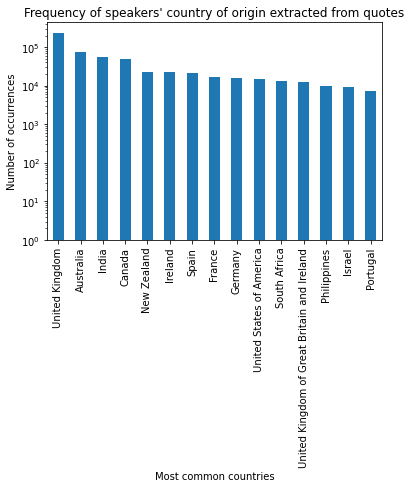

In [ ]:
top_nations = (data2020['nationality'].explode()).value_counts()[:15]
top_nations.plot(kind='bar', log = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common countries")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' country of origin extracted from quotes")
plt.show()

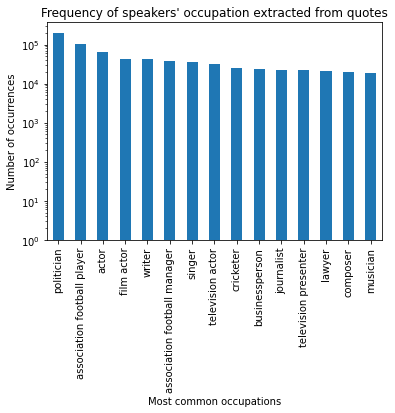

In [ ]:
top_nations = (data2020['occupation'].explode()).value_counts()[:15]
top_nations.plot(kind='bar', log = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation extracted from quotes")
plt.show()

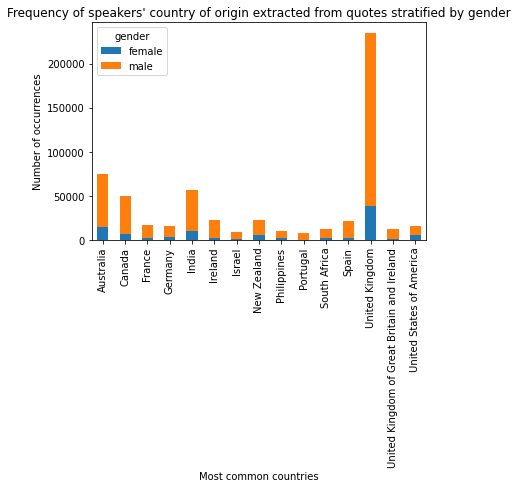

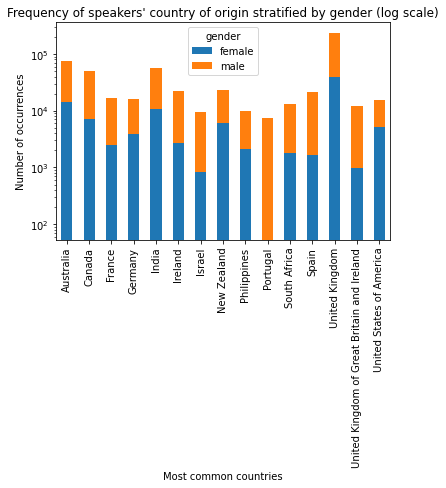

In [ ]:
nationality_exploded = data2020.explode('nationality')
top_nations_list = nationality_exploded['nationality'].value_counts()[:15]
top_nations_df = nationality_exploded[nationality_exploded['nationality'].isin(top_nations_list.keys())]
top_nations = top_nations_df.groupby(['nationality','gender'])['nationality'].count().unstack('gender')

top_nations.plot(kind='bar', stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common countries")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' country of origin extracted from quotes stratified by gender")

top_nations.plot(kind='bar', log = True, stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common countries")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' country of origin stratified by gender (log scale)")

plt.show()

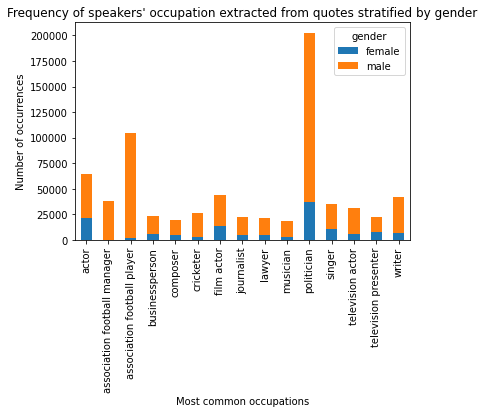

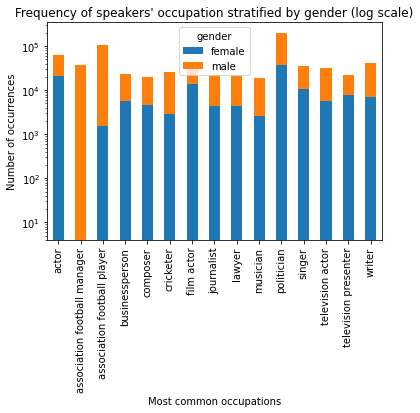

In [ ]:
occupation_exploded = data2020.explode('occupation')
top_occupations_list = occupation_exploded['occupation'].value_counts()[:15]
top_occupations_df = occupation_exploded[occupation_exploded['occupation'].isin(top_occupations_list.keys())]
top_occupations = top_occupations_df.groupby(['occupation','gender'])['occupation'].count().unstack('gender')

top_occupations.plot(kind='bar', stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation extracted from quotes stratified by gender")

top_occupations.plot(kind='bar', log = True, stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation stratified by gender (log scale)")

plt.show()

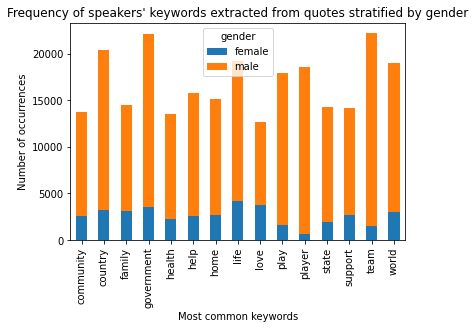

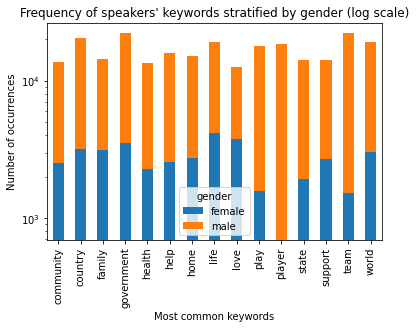

In [ ]:
keywords_exploded = data2020.explode('keywords')
keywords_exploded = keywords_exploded[~keywords_exploded['keywords'].isin(IGNORED_KEYWORDS)]
top_keywords_list = keywords_exploded['keywords'].value_counts()[:15]
top_keywords_df = keywords_exploded[keywords_exploded['keywords'].isin(top_keywords_list.keys())]
top_keywords = top_keywords_df.groupby(['keywords','gender'])['keywords'].count().unstack('gender')

top_keywords.plot(kind='bar', stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common keywords")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' keywords extracted from quotes stratified by gender")

top_keywords.plot(kind='bar', log = True, stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common keywords")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' keywords stratified by gender (log scale)")

plt.show()

## Classifying occupations

In [ ]:
with open("/content/drive/MyDrive/ADA/jobs_sports.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_sports = pd.DataFrame(text,columns=['sports'])

with open("/content/drive/MyDrive/ADA/jobs_media.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_media = pd.DataFrame(text,columns=['media'])

with open("/content/drive/MyDrive/ADA/jobs_important_people.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_important = pd.DataFrame(text,columns=['important'])

with open("/content/drive/MyDrive/ADA/jobs_art.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_art = pd.DataFrame(text,columns=['art'])

with open("/content/drive/MyDrive/ADA/jobs_academics.txt", 'r') as f:
    text = [line for line in f.read().split('\n')]
df_academics = pd.DataFrame(text,columns=['academics'])

In [ ]:
list_sports = list(df_sports.sports)
list_media = list(df_media.media)
list_important = list(df_important.important)
list_art = list(df_art.art)
list_academics = list(df_academics.academics)

In [ ]:
Class_Occupation = []

for val in data2020.occupation:
  person_occ = []
  for occ in val:
    if occ in list_sports:
      person_occ.append('Sport')
    if occ in list_media:
      person_occ.append('Media')
    if occ in list_important:
      person_occ.append('P.E.M')
    if occ in list_art:
      person_occ.append('Art')
    if occ in list_academics:
      person_occ.append('Academics')
    else: 
      person_occ.append('Other')
  Class_Occupation.append(person_occ)


In [ ]:
data2020['Class_Occup'] = pd.Series(Class_Occupation)

In [ ]:
data2020.tail(7000)

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,Class_Occup
650211,23413,1,male,"[politician, entrepreneur, engineer]",[Indonesia],107,High,"[first, capital, city, mass, private, transpor...",[Other]
650212,23414,1,male,"[politician, businessperson]",[Indonesia],107,High,"[standard, building, already, regulated, proto...","[Academics, Other]"
650213,23415,1,male,[politician],[Indonesia],107,High,"[used, get, better, business, everything, shut]",[Other]
650214,23416,1,female,[singer],[Indonesia],107,High,"[definitely, need, donation, serve, medical, w...","[P.E.M, Other, Art, Other, Academics, Other]"
650215,23417,2,female,[politician],"[Ireland, United Kingdom]",2,Very High,"[want, rent, frozen, want, good, quality, chil...","[Academics, Other]"
...,...,...,...,...,...,...,...,...,...
657236,30438,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[mostly, responding, imitating, tolkien, showi...",NaN
657237,30439,1,male,[sport cyclist],"[Eritrea, Kingdom of the Netherlands]",180,Low,"[predict, small, amount, time, new, technology...",NaN
657238,30440,1,male,"[artist, poet, painter]",[Suriname],97,High,"[motto, keep, prestige, keep, customer]",NaN
657239,30441,1,male,"[writer, university teacher]",[Gabon],119,High,"[think, got, access, flight, area, climbing, w...",NaN


In [ ]:
Class_Occup_dummies = pd.get_dummies(data2020.Class_Occup.explode())
jobs_columns = [f'{Class_Occup}_jobs' for Class_Occup in Class_Occup_dummies.columns] 
Class_Occup_dummies.columns = jobs_columns
data_new = pd.concat([data2020, Class_Occup_dummies], axis = 1)
data_new.head()

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,Class_Occup,Academics_jobs,Art_jobs,Media_jobs,Other_jobs,P.E.M_jobs,Sport_jobs
0,0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]","[Other, Other]",0,0,0,1,0,0
0,0,1,male,"[architect, urban planner]",[Luxembourg],23,Very High,"[city, accident, result, coherent, vision, aim]","[Other, Other]",0,0,0,1,0,0
1,1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...","[Sport, Other]",0,0,0,0,0,1
1,1,3,male,[volleyball player],[Luxembourg],23,Very High,"[theyre, biggest, supporter, always, justifica...","[Sport, Other]",0,0,0,1,0,0
2,2,1,male,[gymnast],[Luxembourg],23,Very High,"[anzac, day, traditional, day, recognise, seri...",[Other],0,0,0,1,0,0


In [ ]:
data_new.drop(data_new[data_new['Other_jobs'] == 1].index, inplace = True)
data_new.dropna(axis=0, how='any',inplace=True)
data_new

,index,numOccurrences,gender,occupation,nationality,HDI rank,Development,keywords,Class_Occup,Academics_jobs,Art_jobs,Media_jobs,Other_jobs,P.E.M_jobs,Sport_jobs
26,26,1,male,[biochemist],[United Kingdom],13,Very High,"[collaborative, opioid, stewardship, program, ...",[Academics],1,0,0,0,0,0
96,96,1,male,[historian],[United Kingdom],13,Very High,"[step, position, university, councillor]",[Academics],1,0,0,0,0,0
114,114,2,male,[immunologist],[United Kingdom],13,Very High,"[might, perhaps, slightly, jumped, gun]",[Academics],1,0,0,0,0,0
122,122,1,male,[zoologist],[United Kingdom],13,Very High,"[hoping, public, might, able, provide, valuabl...",[Academics],1,0,0,0,0,0
153,153,1,male,[geographer],[United Kingdom],13,Very High,"[little, bit, datadriven]",[Academics],1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650836,24038,1,male,[rugby union player],[Ireland],2,Very High,"[good, thing, there, fine, line, excited, emot...","[Academics, Academics, Academics]",1,0,0,0,0,0
650837,24039,1,male,[rugby union player],[Ireland],2,Very High,"[good, thing, there, fine, line, excited, emot...","[Academics, Academics, Academics]",1,0,0,0,0,0
650837,24039,1,male,[rugby union player],[Ireland],2,Very High,"[good, thing, there, fine, line, excited, emot...","[Academics, Academics, Academics]",1,0,0,0,0,0
650837,24039,1,male,[rugby union player],[Ireland],2,Very High,"[good, thing, there, fine, line, excited, emot...","[Academics, Academics, Academics]",1,0,0,0,0,0


In [ ]:
chi2, p_values = find_correlation(data2020)

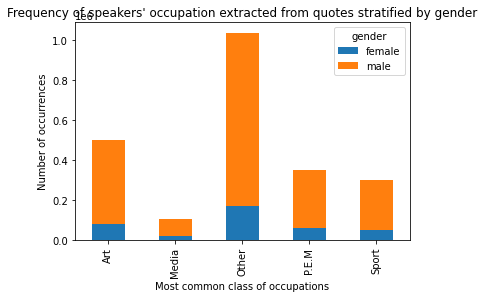

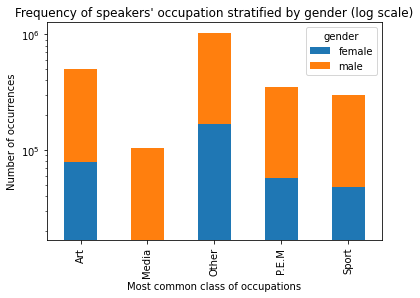

In [ ]:
class_occ_exploded = data2020.explode('Class_Occup')
top_class_occ_list = class_occ_exploded['Class_Occup'].value_counts()[:15]
top_class_occ_df = class_occ_exploded[class_occ_exploded['Class_Occup'].isin(top_class_occ_list.keys())]
top_class_occ = top_class_occ_df.groupby(['Class_Occup','gender'])['Class_Occup'].count().unstack('gender')

top_class_occ.plot(kind='bar', stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common class of occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation extracted from quotes stratified by gender")

top_class_occ.plot(kind='bar', log = True, stacked = True)
#plt.xticks(rotation=45)
plt.xlabel("Most common class of occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation stratified by gender (log scale)")

plt.show()

In [ ]:
# Here we would like to observe the same thing as above but stratified by gender

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def viewbar(feature, n=10):
  plt.figure(figsize=(16,8))
  plt.bar(*zip(*agg_2020[feature+'_frequency'].most_common(n+1)[1:]),color='pink')
  plt.bar(*zip(*agg_2020[feature+'_male_frequency'].most_common(n+1)[1:]),color='blue')
  plt.xlabel(f"Most common {feature}")
  plt.ylabel("Number of occurrences")
  plt.title(f"Frequency of the most common speakers' {feature} extracted from quotes and stratified by gender")
  plt.xticks(rotation=45)

  plt.legend(handles=[mpatches.Patch(color='pink', label='female'),mpatches.Patch(color='blue', label='male')])
  plt.show()

viewbar('countries')

In [ ]:
viewbar('occupations')

In [ ]:
plt.bar(*zip(*agg_2020['words_frequency'].most_common(10)))
plt.xlabel("Most common words")
plt.ylabel("Number of occurrences")
plt.title("Frequency of the most common words extracted from quotes")
plt.xticks(rotation=45)
plt.show()

## Relative keywords change

As we can see from the graph with the frequency of the most common keywords above, those words are not very meaningful and do not give us any insights, and many of them are filler or syntax words.

Therefore, we shift our strategy of looking at the keywords, and instead of viewing them through the absolute values of occurences, we want to inspect new trends occuring in the dataset.

For that, we look at the relative change of the keywords over the years. We are interested in two kinds of trends

1. New words words that were not present the year before
2. Words with a relatively big spike of occurences

Doing this naively generates noise - a word with a seemingly huge relative change (10 times more popular) could be just used 10 times as opposed to once the last year. Do deal with this noise, we set a treshold of minimal number of occurences to consider a word.

In [ ]:
RELEVANCE_THRESHOLD = 100

def get_interval(y1, y2):
  '''Creates interval between two years.'''

  return f"{y1}-{y2}"

def unfold_interval(i):
  return list(map(int, i.split('-')))


def relative_change_in_time(years_agg, years):
  '''Calculates the relative change of keywords over time.'''

  first_year = years[0]
  relative_change = defaultdict(lambda : {}) 
  
  # stocks dictionaries for each year
  dictionaries = {year: years_agg[year]['words_frequency'] for year in years}

  # if the word was present in the previous dictionary already and its count was bigger 
  # than a threshold, then we add the relative count between the two years
  for year, frequencies in dictionaries.items():
      if year == first_year:
        continue
      for word, count in frequencies.items():
          previous_count = dictionaries.get(year-1, {}).get(word, 0)
          key = get_interval(year-1, year)
          if count < RELEVANCE_THRESHOLD and previous_count != 0:
            relative_change[key][word] = -1
          elif previous_count != 0:
            relative_change[key][word] = count / previous_count
          else:
            relative_change[key][word] = None
  return relative_change


def highest_spikes(relative_change, interval, count=1):
  '''Finds the biggest relative changes.'''

  changes = filter(lambda x: x[1] is not None, relative_change[interval].items())
  return sorted(changes, key=lambda x: x[1], reverse=True)[:count]


def new_trending_words(years_agg, relative_change, interval, count):
  '''Finds the new appearing words.'''

  new_year = unfold_interval(interval)[1]
  get_freq = lambda word: years_agg[new_year]['words_frequency'][word]

  return Counter({
      word: get_freq(word)
      for word, change in relative_change[interval].items()
      if change is None
  }).most_common(count)

In [ ]:
# Let's show how it works with a little demo

years = [2018, 2019]
years_agg = run_chunks_across_years(years, chunk_size=200_000, num_of_chunks=10)

In [ ]:
r_t = relative_change_in_time(years_agg, years)

TypeError: ignored

In [ ]:
highest_spikes(r_t, get_interval(years[0], years[1]), 30)

In [ ]:
new_trending_words(years_agg, r_t, get_interval(years[0], years[1]), 20)

## Women representation

Finally, we want to observe the relative representation of women in the most common occupations among the most frequent countries.

In [ ]:
# Finding the 10 most recurring countries and occupations in the speaker_attrs dataset
from collections import Counter
Q_CODES_COLUMNS = ['nationality', 'occupation', 'gender']

#Define a simpler dataframe with only the colums that interests us
speaker_attrs_simp = pd.DataFrame(speaker_attrs, columns = Q_CODES_COLUMNS)

discard_na(speaker_attrs_simp,'nationality')
discard_na(speaker_attrs_simp,'occupation')

all_countries = Counter(list(speaker_attrs_simp.nationality.explode()))
all_occupations = Counter(list(speaker_attrs_simp.occupation.explode()))


most_common_countries = all_countries.most_common(10)
most_common_occupations = all_occupations.most_common(10)
top_common_countries = [a_tuple[0] for a_tuple in most_common_countries]
top_common_occupations = [a_tuple[0] for a_tuple in most_common_occupations]

speaker_attrs_simp = speaker_attrs_simp.explode('nationality')
speaker_attrs_simp = speaker_attrs_simp.explode('occupation')
speaker_attrs_simp = speaker_attrs_simp.explode('gender')

In [ ]:
# Restricting the dataframe to work only with the most common countries, occupations and genders

countries = speaker_attrs_simp[speaker_attrs_simp['nationality'].isin(top_common_countries)]
countries = countries[countries['occupation'].isin(top_common_occupations)]
countries = countries[countries['gender'].isin(['female','male'])]

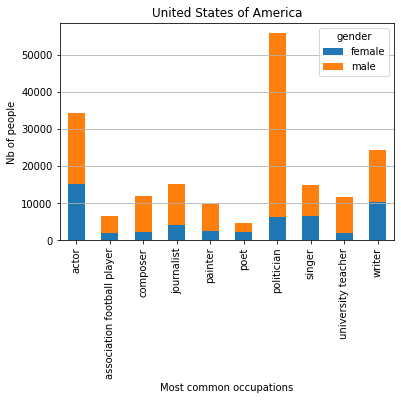

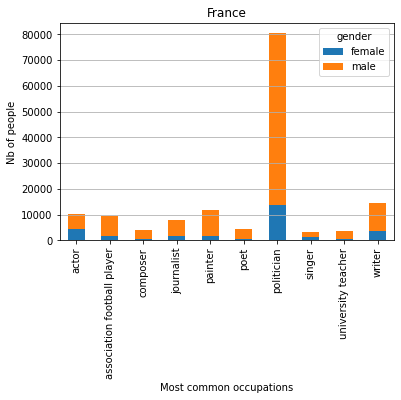

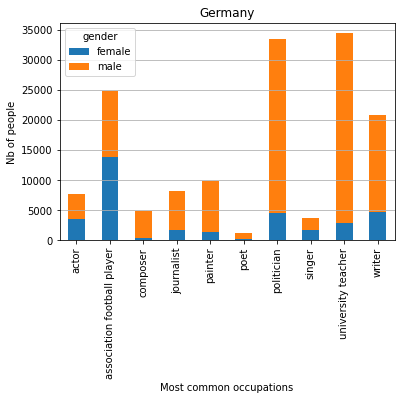

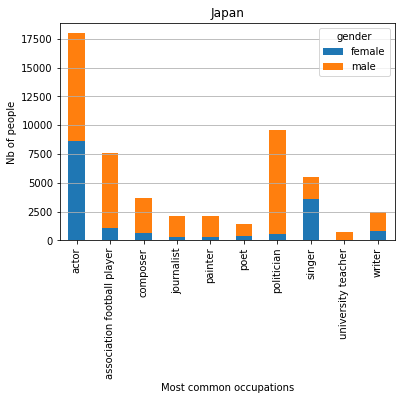

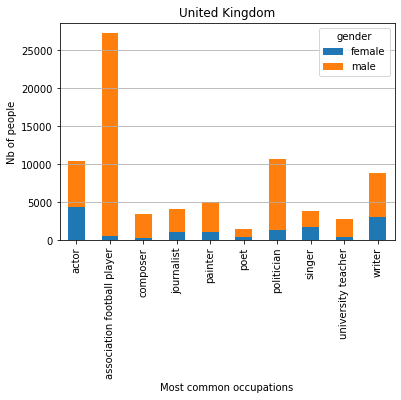

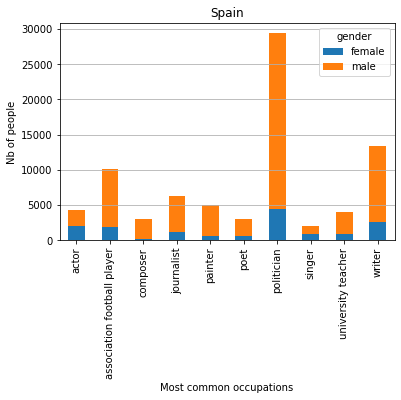

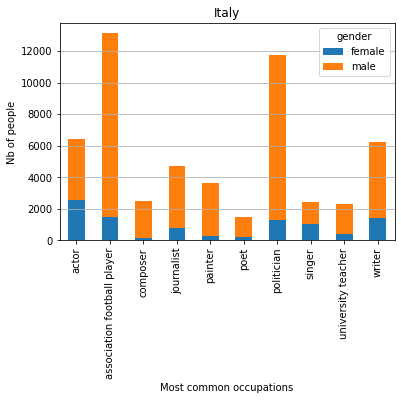

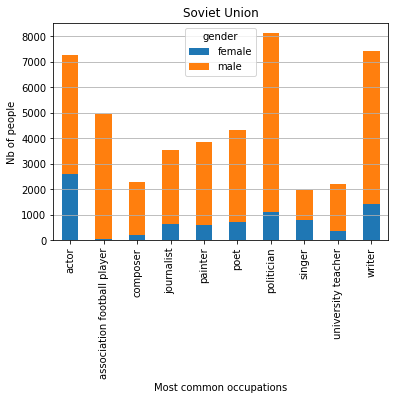

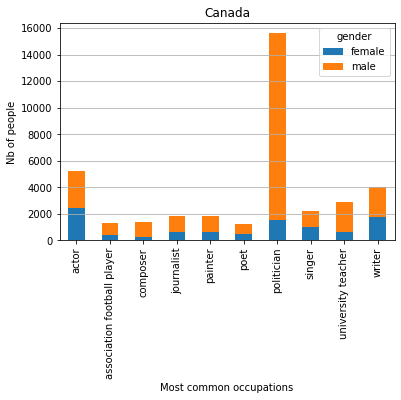

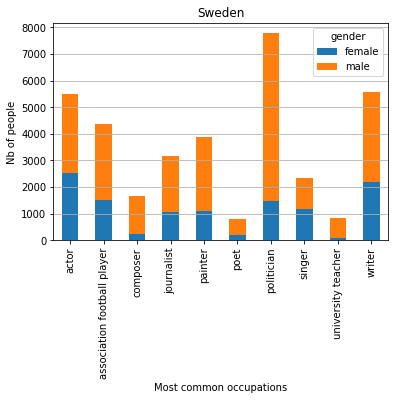

In [ ]:
# Plot of the distribution of the 10 most common occupations stratified by gender for each of the 10 most common countries

for i in range(len(list(countries['nationality'].value_counts()))):
  subset = countries[countries['nationality'] == top_common_countries[i]]
  ax = pd.crosstab(subset['occupation'],subset['gender']).plot(kind='bar', stacked=True)
  ax.yaxis.grid(True)
  ax.set_title(f'{top_common_countries[i]}')
  ax.set_xlabel('Most common occupations')
  ax.set_ylabel('Nb of people')

We will perform tests for correlations to assess any relationships between the features and the success of the quote.

In [ ]:
# Test with linear model :
# - How to unify all the chunks together to have a better model ?
# - Since we process chunk by chunk can we combine models ?
# - 

In [ ]:
import seaborn as sns
processed_chunk_df = processed_chunk_df.explode('occupation')
processed_chunk_df_new = pd.DataFrame(processed_chunk_df, columns = ['occupation', 'N',	'Development',	'g'])
processed_chunk_df_dummies = pd.get_dummies(processed_chunk_df_new)